In [1]:
import pandas as pd
import numpy as np
from pymongo import MongoClient
from functools import reduce
from operator import add
import matplotlib.pyplot as plt
import seaborn

import src.pipe as pipe

plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [3]:
import xgboost as xgb

/home/ubuntu/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/ubuntu/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [4]:
def present_cv(cv):
    arr=[]
    for key in cv.keys():
        mu = np.mean(cv[key])
        st = np.std(cv[key])
        arr.append([key, mu, st])
    return pd.DataFrame(arr, columns=['metric', 'mean', 'std'])

### Without labels, with popularity

In [7]:
bbd = pipe.BillboardData() 
bbd.transform_for_models()

In [8]:
df = bbd.df.copy().drop(columns='label')

In [9]:
rand = 7
_y = df.pop('on_billboard').values
_X = df.values
X_train, X_test, y_train, y_test = train_test_split(_X, _y, test_size=0.1)

In [10]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1)

cv = cross_validate(rf, X_train, y_train, scoring=['accuracy', 'recall', 'precision'],
              n_jobs=-1, cv=5, return_train_score=False)
present_cv(cv)

,metric,mean,std
0,fit_time,2.073694,0.601330
1,score_time,0.346097,0.021179
2,test_accuracy,0.859258,0.002475
3,test_recall,0.868750,0.007155
4,test_precision,0.863346,0.002578


### With dummyized labels, with popularity

In [26]:
bbd2 = pipe.BillboardData() 
bbd2.transform_for_models()
bbd2.dummyize_record_label()

Size after merge: (13501, 999)


In [27]:
df = bbd2.df.copy()

In [28]:
rand = 7
_y = df.pop('on_billboard').values
_X = df.values
X_train, X_test, y_train, y_test = train_test_split(_X, _y, test_size=0.1)

In [29]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1)

cv = cross_validate(rf, X_train, y_train, scoring=['accuracy', 'recall', 'precision'],
              n_jobs=-1, cv=5, return_train_score=False)
present_cv(cv)

,metric,mean,std
0,fit_time,2.759473,0.887193
1,score_time,0.314231,0.002083
2,test_accuracy,0.847820,0.005405
3,test_recall,0.861302,0.010181
4,test_precision,0.848551,0.003159


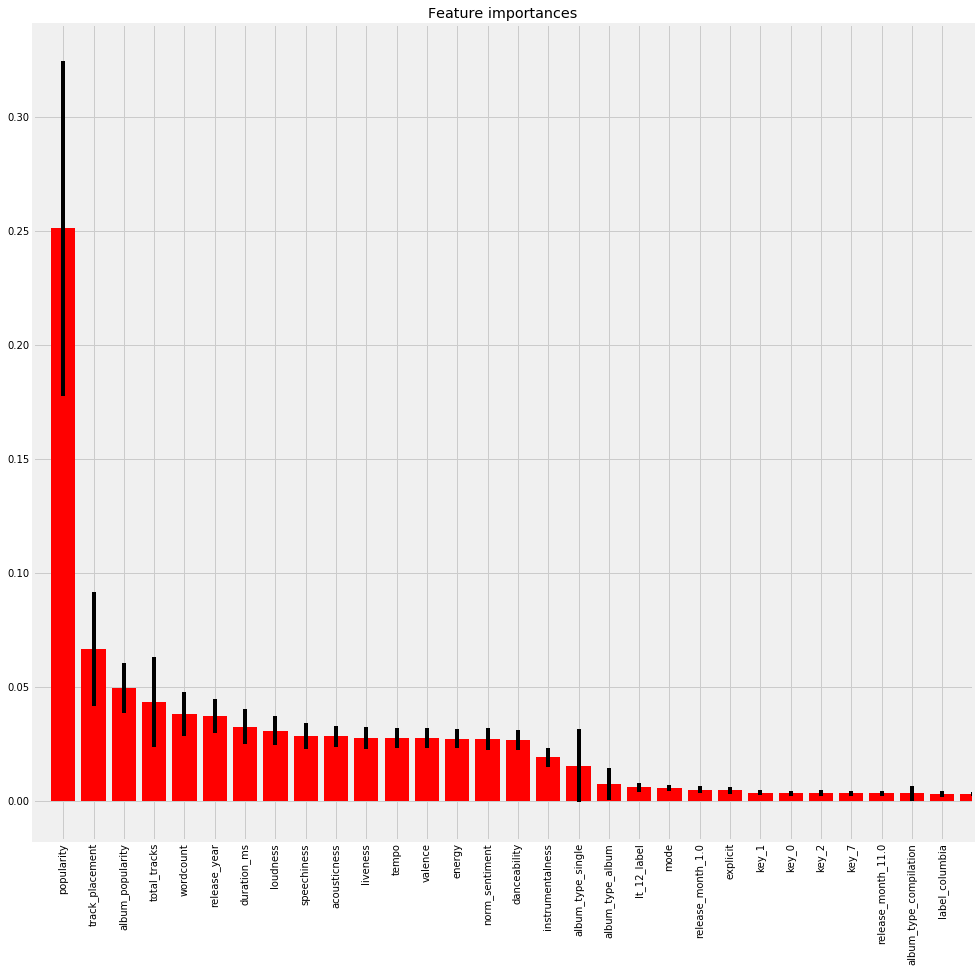

In [30]:
rf.fit(X_train, y_train)
plot_feature_importances(X_train, rf, 30, df.columns)

### Without labels, without popularity

In [31]:
bbd = pipe.BillboardData() 
bbd.transform_for_models()
bbd.drop_popularities()

In [32]:
df = bbd.df.copy().drop(columns='label')

In [33]:
rand = 7
_y = df.pop('on_billboard').values
_X = df.values
X_train, X_test, y_train, y_test = train_test_split(_X, _y, test_size=0.1)

In [34]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1)

cv = cross_validate(rf, X_train, y_train, scoring=['accuracy', 'recall', 'precision'],
              n_jobs=-1, cv=5, return_train_score=False)
present_cv(cv)

,metric,mean,std
0,fit_time,2.337465,0.729486
1,score_time,0.322829,0.012035
2,test_accuracy,0.681812,0.009065
3,test_recall,0.662464,0.009981
4,test_precision,0.709353,0.011576


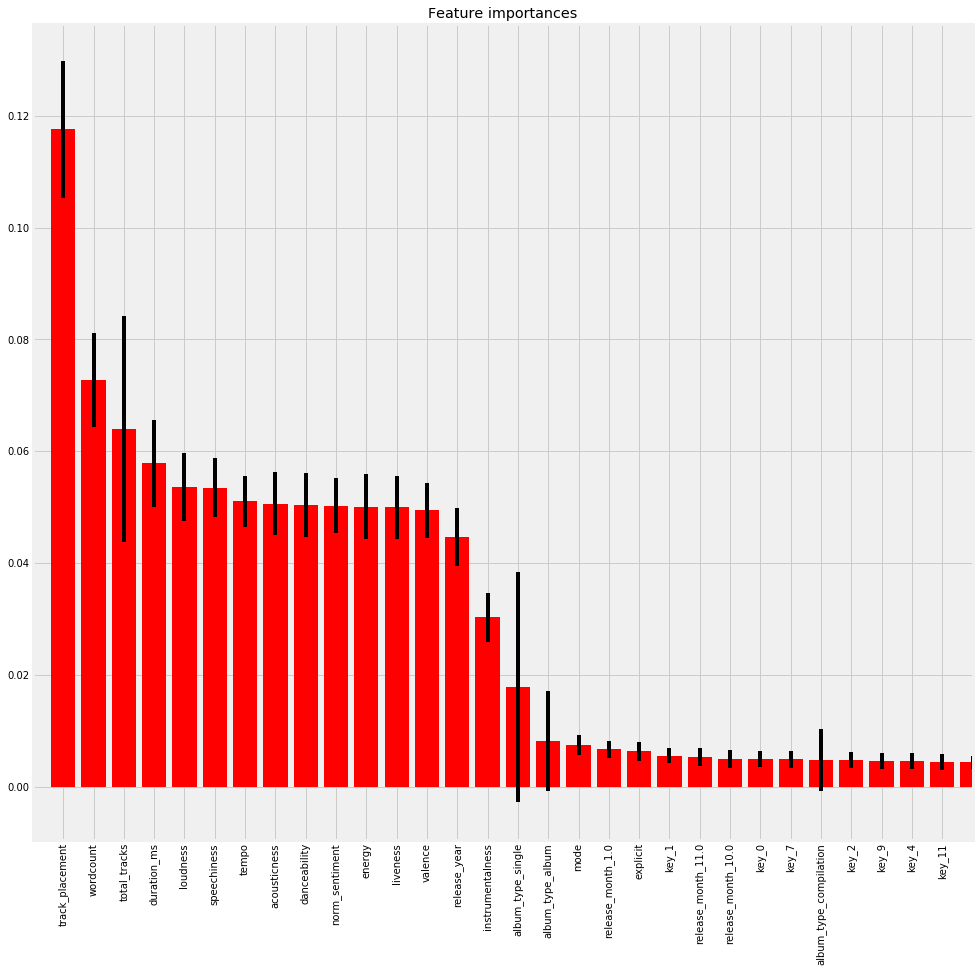

In [35]:
rf.fit(X_train, y_train)
plot_feature_importances(X_train, rf, 30, df.columns)

### With dummyized labels, without popularity

In [19]:
bbd2 = pipe.BillboardData() 
bbd2.transform_for_models()
bbd2.dummyize_record_label()
bbd2.drop_popularities()

Size after merge: (13501, 999)


In [20]:
df = bbd2.df.copy()

In [21]:
rand = 7
_y = df.pop('on_billboard').values
_X = df.values
X_train, X_test, y_train, y_test = train_test_split(_X, _y, test_size=0.1)

In [22]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1)

cv = cross_validate(rf, X_train, y_train, scoring=['accuracy', 'recall', 'precision'],
              n_jobs=-1, cv=5, return_train_score=False)
present_cv(cv)

,metric,mean,std
0,fit_time,3.111158,1.007291
1,score_time,0.319024,0.005876
2,test_accuracy,0.702303,0.009956
3,test_recall,0.685806,0.016722
4,test_precision,0.729238,0.011982


In [23]:
def plot_feature_importances(X, model, max_feats, feature_labels):
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
#     print("Feature ranking:")
#     for f in range(min(X.shape[1],max_feats)):
#         print("%d. feature %s (%f)" % (f + 1, df.columns[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure(figsize=(15,15))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(min(X.shape[1], max_feats)), feature_labels[indices], rotation='vertical')
    plt.xlim([-1, min(X.shape[1], max_feats)])
    
    plt.show()

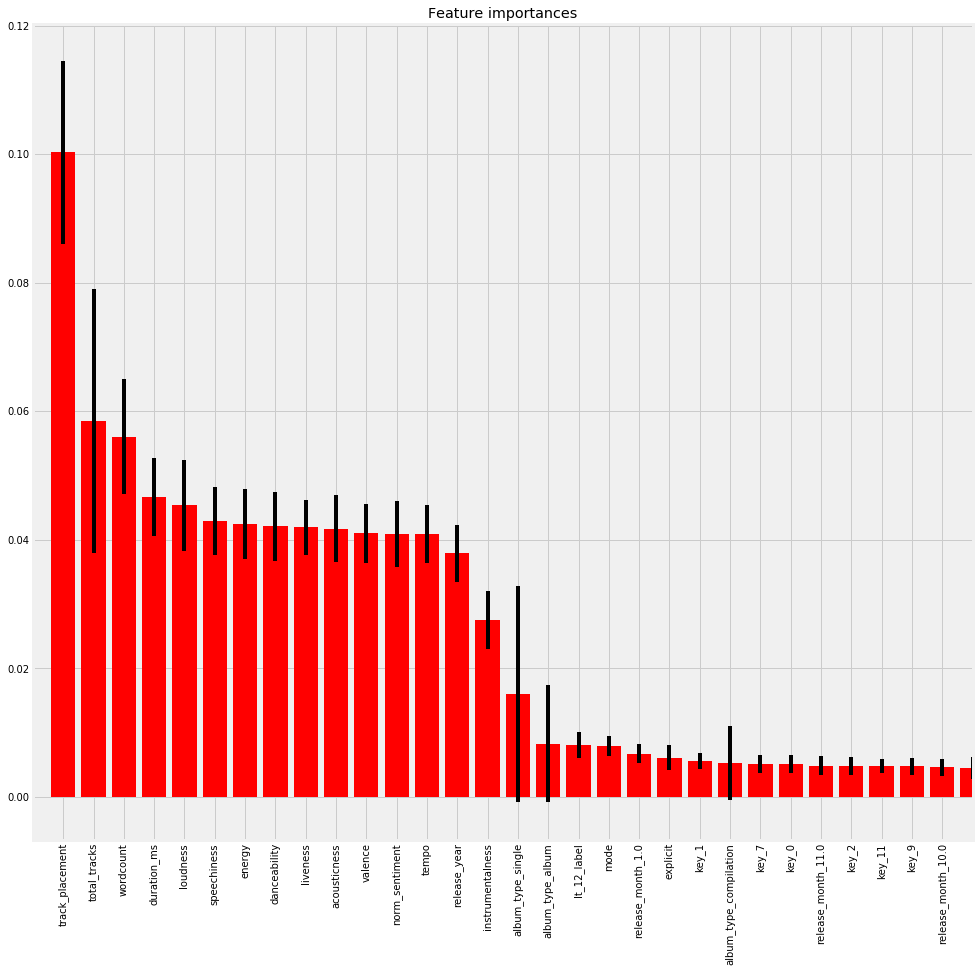

In [25]:
rf.fit(X_train, y_train)
plot_feature_importances(X_train, rf, 30, df.columns)